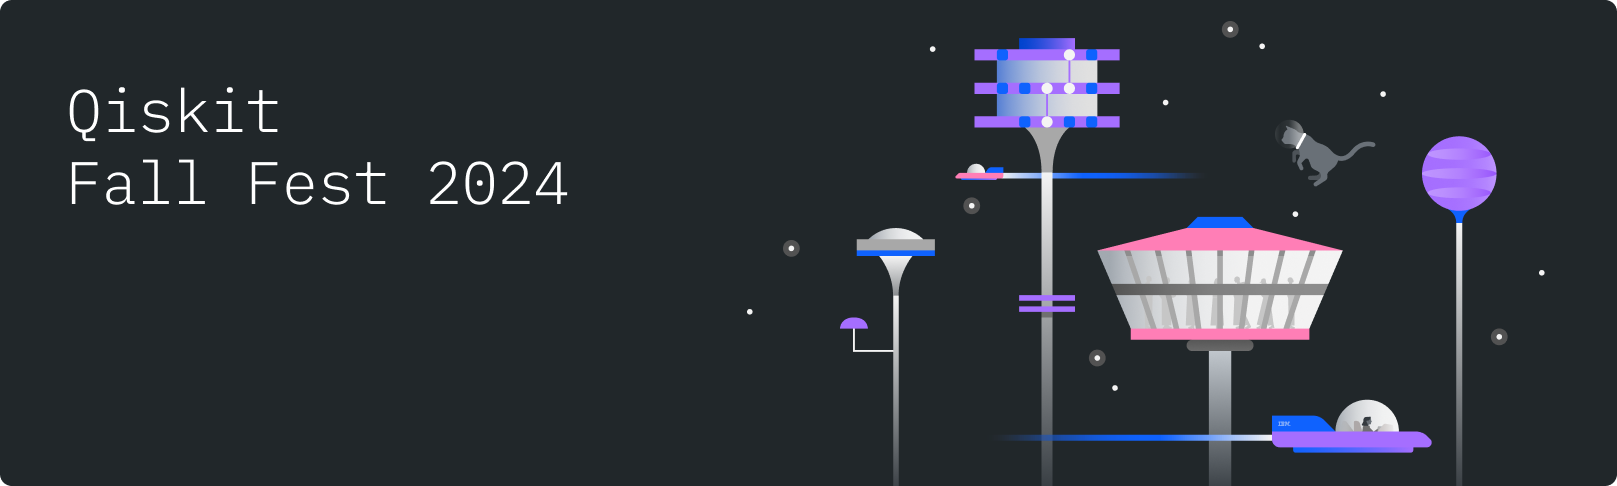

# Open Notebook B: CHSH Inequality

- Guided Tutorial

- Usage estimate: 3-4 minutes of chip time on ibm\_sherbrooke.

*(NOTE: This is an estimate only. Your runtime may vary. This does not include queue time)*

Hi there and welcome to the **Qiskit Fall Fest**!

Whether you're a total beginner or a PhD candidate in quantum physics, there is something here for you. Thanks for joining us.  😀

As part of the Qiskit Fall Fest, IBM Quantum has created a series of notebooks for you to work through, which include coding challenges and Qiskit tutorials.

The Qiskit Fall Fest is a massive event, featuring thousands of students worldwide who are all learning about quantum computing and Qiskit. Just by being here, you're helping to make history. Your participation is helping to shape what the future of the industry will look like. Congratulations and welcome!

### Open Notebook

This is an Open Notebook, which means it has tutorials and code examples but does not use an auto-grader. There are no requirements you need to meet in order to "finish" this notebook. You can use this as a personal learning tool, a group project, or a workshop resource. Each Open Notebook is meant to help you better understand Qiskit and quantum computing in general.

**Open Notebook B** will cover the CHSH inequality. It will guide you through how to run an experiment on a quantum computer to demonstrate a violation of the inequality, using the Estimator primitive.

---

In each notebook, you will find links to documentation, tutorials, and other helpful resources you might need to solve that particular problem. You can also find most of these resources on IBM's new home for quantum education: [IBM Quantum Learning](https://learning.quantum.ibm.com/).

If you have never used Python before, you will **definitely** struggle with these notebooks. We recommend you [go learn the basics of Python before continuing](https://www.learnpython.org/).

## Setup
<a name="setup"></a>

It should be obvious, but you need to have Qiskit installed to correctly finish each notebook within the Qiskit Fall Fest. Most participants of the Qiskit Fall Fest are likely running this notebook in a cloud-based tool [like Google Colab](https://colab.research.google.com/) or [qBraid](https://www.qbraid.com/), so our instructions are built towards that.

Below is some code to install Qiskit within your current environment.

In [ ]:
### INSTALL QISKIT inside your cloud-based environment

%pip install qiskit[visualization]
%pip install qiskit_aer
%pip install qiskit_ibm_runtime

In [1]:
### Import the required packages

# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

#### Save your IBM Quantum account

1.   Navigate to the [IBM Quantum Platform](https://quantum.ibm.com/) and log in
2.   Look to the top right corner, click and copy your API token (pictured above)
3.   In the code cell below, replace `Your_token_here` with your token
4.   Make sure your token is inside the quotation marks!!

In [2]:
## Save your IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="5b5ba22167a7d05f9446324772f5c7fde9af8872ea73eb65e2c5191f2e3a7ce3c7abf141b3861759aeeeb10269830ad1b2e0fdad43d0c14ff72fac60f33aa832",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

## The CHSH inequality

The CHSH inequality, named after the authors Clauser, Horne, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics.

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments with entangled photons demonstrating violation of Bell’s inequalities.


For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit $A$ and $a$ and the bases for the second qubit $B$ and $b$.  This allows us to compute the CHSH quantity $S_1$:

$$
S_1 = A(B-b) + a(B+b).
$$

Each observable is either $+1$ or $-1$. Clearly, one of the terms $B\pm b$ must be $0$, and the other must be $\pm 2$.  Therefore, $S_1 = \pm 2$. The average value of $S_1$ must satisfy the inequality:

$$
|\langle S_1 \rangle|\leq 2.
$$

Expanding $S_1$ in terms of $A$, $a$, $B$, and $b$ results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

You can define another CHSH quantity $S_2$:

$$
S_2 = A(B+b) - a(B-b),
$$

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$

If quantum mechanics can be described by local hidden variable theories, the previous inequalities must hold true. However, as is demonstrated in this notebook, these inequalities can be violated in a quantum computer.  Therefore, quantum mechanics is not compatible with local hidden variable theories.


If you want to learn more theory, explore [Entanglement in Action](https://learning.quantum-computing.ibm.com/course/basics-of-quantum-information/entanglement-in-action#the-chsh-game) with John Watrous.

<iframe loading="lazy" width="800" height="450" style="margin-top: 40px; margin-bottom: 40px;" src="https://www.youtube.com/embed/GSsElSQgMbU?si=ZhRKJKHMLRq0g3E1&amp;start=2426" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


You will create an entangled pair between two qubits in a quantum computer by creating the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$. Using the Estimator primitive, you can directly obtain the expectation values needed ($\langle AB \rangle, \langle Ab \rangle, \langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities $\langle S_1\rangle$ and $\langle S_2\rangle$. Before the introduction of the Estimator primitive, you would have to construct the expectation values from the measurement outcomes.

You will measure the second qubit in the $Z$ and $X$ bases.  The first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. As you will see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, you only need to create *one* CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, you will analyze the results and plot them against the measurement angle. You will see that for certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1\rangle| > 2$ or $|\langle S_2\rangle| > 2$, which demonstrates the violation of the CHSH inequality.


## Step 1: Map classical inputs to a quantum problem
<a name="step1"></a>

### Create a parameterized CHSH circuit

First, we write the circuit with the parameter $\theta$, which we call `theta`. The [`Estimator` primitive](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. `Estimator` (V2) primitive can automatically change measurement basis based on the supplied observable.


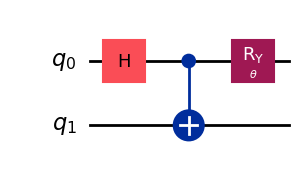

In [3]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### Create a list of phase values to be assigned later

After creating the parameterized CHSH circuit, you will create a list of phase values to be assigned to the circuit in the next step. You can use the following code to create a list of 21 phase values range from $0$ to $2 \pi$ with equal spacing, that is, $0$, $0.1 \pi$, $0.2 \pi$, ..., $1.9 \pi$, $2 \pi$.


In [4]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)

# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### Observables

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$ rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.


In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

## Step 2: Optimize problem for quantum execution
<a name="step2"></a>

In [6]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_brisbane'

To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).


### ISA Circuit


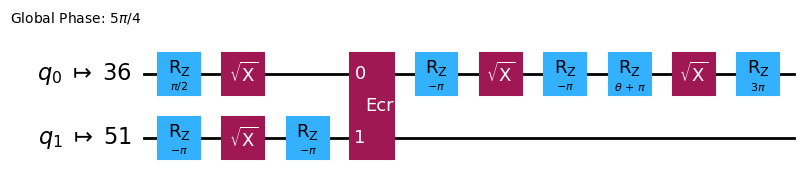

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables


Similarly, we need to transform the observables to make it backend compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). We can perform the transformation using the `apply_layout` the method of `SparsePauliOp` object.


In [8]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

## Step 3: Execute using Qiskit primitives

In order to execute the entire experiment in one call to the [`Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2).


We can create a [Qiskit Runtime `Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) primitive to compute our expectation values. The `EstimatorV2.run()` method takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [9]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job = estimator.run(pubs=[pub])
print(job.job_id())

cx10wwvbqkhg0083kk70


We printed the Job ID because this may take a while to run. With the job ID, you can come back to this notebook later on and finish directly from the next section by referencing the job ID. Make sure to save that job id!

## Step 4: Post-process, return result in classical format

If you are running in the cloud or started a new kernel, you may need to [reinstall Qiskit and re-import your packages](#setup) before the next step. You also need to save your API token again and define the `service` variable. All of these steps are contained in the code cells in the [Setup section](#setup).

In [10]:
## Collect the results of the job
## Remember if you are in the cloud, you may need to reinstall Qiskit, re-import packages, and save your API token

job_id = "cx10wwvbqkhg0083kk70"

job = service.job(job_id)

job_result = job.result()

The estimator returns expectation values for both of the observables, $\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle$ and $\langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle$.

Once again, if you restarted your runtime, you'll have to run the code cells in [Step 1](#step1) and [Step 2](#step2) again to make sure your variables can be called correctly.

**You do not need to re-run Step 3**, which was when you actually sent your circuit to be run on the quantum backend. You saved the job id from that step, which allows you to skip.

In [11]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

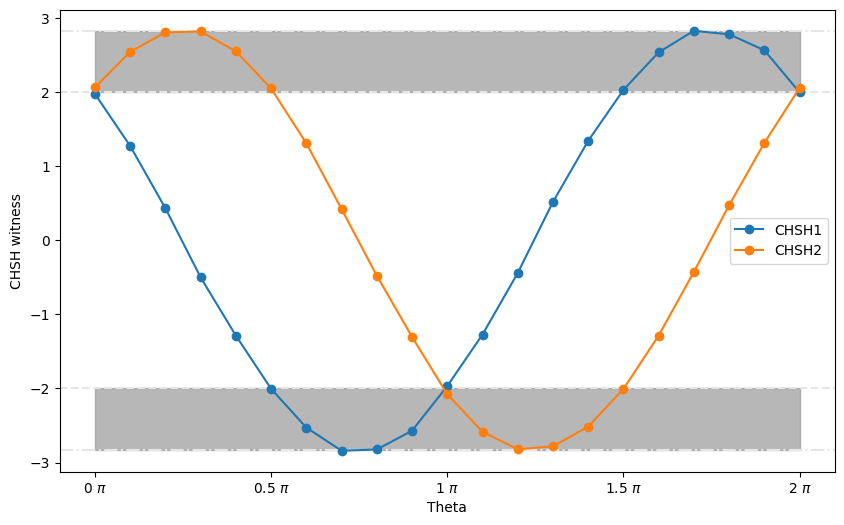

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In the figure, the lines and gray areas delimit the bounds; the outer-most (dash-dotted) lines delimit the quantum-bounds ($\pm 2$), whereas the inner (dashed) lines delimit the classical bounds ($\pm 2\sqrt{2}$). You can see that there are regions where the CHSH witness quantities exceeds the classical bounds. Congratulations! You have successfully demonstrated the violation of CHSH inequality in a real quantum system!


In [13]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.30.0'

In [14]:
import qiskit

qiskit.version.get_version_info()

'1.2.4'